In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import calendar
import pickle

%matplotlib inline
plt.style.use('seaborn-pastel')

import seaborn as sns
sns.set(style="whitegrid")

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve
from sklearn.metrics import roc_auc_score, roc_curve

%run evaluation_functions.py

In [2]:
with open('pickles/appt_v2.pickle','rb') as read_file:
    appt = pickle.load(read_file)
    
appt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25453 entries, 1 to 39983
Data columns (total 37 columns):
PatientId              25453 non-null float64
AppointmentID          25453 non-null int64
Gender                 25453 non-null object
ScheduledDay           25453 non-null object
AppointmentDay         25453 non-null object
Age                    25453 non-null int64
Neighbourhood          25453 non-null object
Scholarship            25453 non-null int64
Hipertension           25453 non-null int64
Diabetes               25453 non-null int64
Alcoholism             25453 non-null int64
Handcap                25453 non-null int64
SMS_received           25453 non-null int64
No_show                25453 non-null object
No_show_num            25453 non-null int64
SchedDay               25453 non-null datetime64[ns]
SchedTime              25453 non-null object
SchedDayofWeek         25453 non-null object
ApptDay                25453 non-null datetime64[ns]
ApptDayofWeek          25453

### EDA

0    0.719758
1    0.280242
Name: No_show_num, dtype: float64


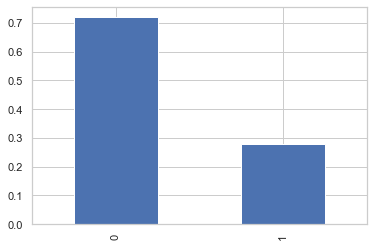

In [3]:
target_pcts = appt['No_show_num'].value_counts(normalize=True) 
print(target_pcts)

target_pcts.plot(kind='bar');

/Users/Jocelyn/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/Jocelyn/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


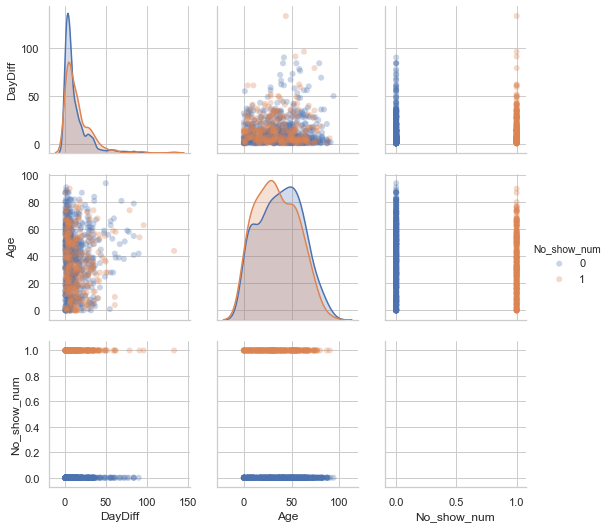

In [4]:
def plot_features(df, sample_size=500):
    
    sample = (df[['DayDiff','Age','Gender','No_show_num']].sample(1000, random_state=44)) 
    sns.pairplot(sample,hue='No_show_num', plot_kws=dict(alpha=.3, edgecolor='none'))

plot_features(appt)

### Modeling set up

In [5]:
#Set features
feature_cols = ['Gender','Age2','Neighbourhood2','Scholarship','Hipertension','Diabetes','Alcoholism',
                'Handcap_bin','SMS_received','SchedDayofWeek','ApptDayofWeek','DayDiff2',
                'PrevAppt_No_show','Reschedule','Follow_up','no_show_rate2','total_appt_count2']
# feature_cols = ['Gender','Age','Scholarship','Hipertension','Diabetes','Alcoholism','Handcap','SMS_received',
#                 'ApptDayofWeek','DayDiff']

a_X = appt[feature_cols]

a_X = pd.get_dummies(a_X, columns = ['Gender','Neighbourhood2','SchedDayofWeek','ApptDayofWeek'])
# a_X = pd.get_dummies(a_X, columns = ['Gender','ApptDayofWeek'],drop_first=True)

a_X.drop(columns=['Gender_F','Neighbourhood2_OTHER','SchedDayofWeek_Monday','ApptDayofWeek_Monday'],inplace=True)

X_cols = np.array(a_X.columns)
a_X.info()
a_X.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25453 entries, 1 to 39983
Data columns (total 87 columns):
Age2                                  25453 non-null int64
Scholarship                           25453 non-null int64
Hipertension                          25453 non-null int64
Diabetes                              25453 non-null int64
Alcoholism                            25453 non-null int64
Handcap_bin                           25453 non-null int64
SMS_received                          25453 non-null int64
DayDiff2                              25453 non-null int64
PrevAppt_No_show                      25453 non-null float64
Reschedule                            25453 non-null int64
Follow_up                             25453 non-null int64
no_show_rate2                         25453 non-null float64
total_appt_count2                     25453 non-null float64
Gender_M                              25453 non-null uint8
Neighbourhood2_ANDORINHAS             25453 non-null uint8


,Age2,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap_bin,SMS_received,DayDiff2,PrevAppt_No_show,Reschedule,...,Neighbourhood2_VILA RUBIM,SchedDayofWeek_Friday,SchedDayofWeek_Saturday,SchedDayofWeek_Thursday,SchedDayofWeek_Tuesday,SchedDayofWeek_Wednesday,ApptDayofWeek_Friday,ApptDayofWeek_Thursday,ApptDayofWeek_Tuesday,ApptDayofWeek_Wednesday
1,23,0,0,0,0,0,1,21,0.0,0,...,0,0,0,0,0,1,0,0,0,1
3,29,0,0,0,0,0,0,4,1.0,1,...,0,1,0,0,0,0,0,0,1,0
5,28,0,0,0,0,0,0,26,1.0,0,...,0,0,0,0,0,1,0,0,0,0
7,80,0,1,0,0,0,1,4,1.0,0,...,0,1,0,0,0,0,0,0,1,0
9,56,0,0,0,0,0,1,6,0.0,0,...,0,0,0,1,0,0,0,0,0,1


In [6]:
#split into training and test sets
X, y = a_X, appt['No_show_num']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 10, stratify = y)

In [7]:
y_train.value_counts()

0    13739
1     5350
Name: No_show_num, dtype: int64

In [8]:
y_test.value_counts()

0    4581
1    1783
Name: No_show_num, dtype: int64

### Basic logistic regression

In [9]:
X_train1 = X_train.drop(columns=['PrevAppt_No_show','Reschedule','Follow_up','no_show_rate2','total_appt_count2'])
X_test1 = X_test.drop(columns=['PrevAppt_No_show','Reschedule','Follow_up','no_show_rate2','total_appt_count2'])
X_cols1 = X_train1.columns

In [10]:
lr = LogisticRegression(solver='liblinear')
lr.fit(X_train1, y_train)
y_pred_test1 = lr.predict(X_test1)

In [11]:
print_scores(y_test,y_pred_test1)

Accuracy score: 0.7210873664362036
F1 score: 0.0273972602739726
Precision (true + / all predicted +): 0.5952380952380952
Recall (true + / all actual +): 0.014021312394840156


In [12]:
for i in range(len(X_cols1)):
    print(X_cols1[i],":",lr.coef_[0][i])

Age2 : -0.0076570049534975485
Scholarship : 0.2801460667585419
Hipertension : -0.218947359966939
Diabetes : 0.13256487277510615
Alcoholism : 0.3281430486167852
Handcap_bin : 0.125861396120126
SMS_received : -0.1376511107244755
DayDiff2 : 0.016746331273817354
Gender_M : -0.09621990722140575
Neighbourhood2_ANDORINHAS : 0.36026378116854835
Neighbourhood2_BARRO VERMELHO : 0.06858300882858905
Neighbourhood2_BELA VISTA : 0.10551829702317098
Neighbourhood2_BENTO FERREIRA : 0.2856743806081419
Neighbourhood2_BOA VISTA : -0.5237379411195552
Neighbourhood2_BONFIM : 0.27729722608639285
Neighbourhood2_CARATOÍRA : 0.18732463175764905
Neighbourhood2_CENTRO : 0.23000529612932014
Neighbourhood2_COMDUSA : -0.03617571937130396
Neighbourhood2_CONQUISTA : 0.02685110269168845
Neighbourhood2_CONSOLAÇÃO : -0.07733605446793078
Neighbourhood2_CRUZAMENTO : -0.0022269427138591692
Neighbourhood2_DA PENHA : 0.0442620010641543
Neighbourhood2_DE LOURDES : -0.5369653465098658
Neighbourhood2_DO CABRAL : -0.373743947243

### Logistic regression with historical variables

In [13]:
# Previous no-show rate only
drop_cols1 = ['PrevAppt_No_show','Reschedule','Follow_up','total_appt_count2']
# Previous no-show - binary only
drop_cols2 = ['Reschedule','Follow_up','no_show_rate2','total_appt_count2']
# Reschedule and follow-up only
drop_cols3 = ['PrevAppt_No_show','no_show_rate2','total_appt_count2']
# Reschedule, follow-up, previous no-show binary
drop_cols4 = ['no_show_rate2','total_appt_count2']
# Reschedule, follow-up, previous no-show rate
drop_cols5 = ['PrevAppt_No_show','total_appt_count2']
# Previous total appt count only
drop_cols6 = ['PrevAppt_No_show','Reschedule','Follow_up','no_show_rate2']
# Reschedule, follow-up, previous total appt count
drop_cols7 = ['PrevAppt_No_show','no_show_rate2']

In [14]:
def logreg_run(drop_cols):
    X_train2 = X_train.drop(columns=drop_cols)
    X_test2 = X_test.drop(columns=drop_cols)

    X_cols2 = X_train2.columns
    
    lr = LogisticRegression(solver='liblinear')
    lr.fit(X_train2, y_train)
    y_pred_test2 = lr.predict(X_test2)
    return print_scores(y_test,y_pred_test2)

In [15]:
# Previous no-show rate only
logreg_run(drop_cols1)

Accuracy score: 0.7283155248271528
F1 score: 0.24596598342782386
Precision (true + / all predicted +): 0.5529411764705883
Recall (true + / all actual +): 0.15816040381379698


In [16]:
# Previous no-show binary only
logreg_run(drop_cols2)

Accuracy score: 0.7327152734129478
F1 score: 0.2708958422631805
Precision (true + / all predicted +): 0.5745454545454546
Recall (true + / all actual +): 0.1772293886707796


In [17]:
# Reschedule and follow-up only
logreg_run(drop_cols3)

Accuracy score: 0.7210873664362036
F1 score: 0.03164211674849973
Precision (true + / all predicted +): 0.58
Recall (true + / all actual +): 0.016264722378014584


In [18]:
# Reschedule, follow-up, previous no-show binary
logreg_run(drop_cols4)

Accuracy score: 0.7363293526084224
F1 score: 0.3105998356614626
Precision (true + / all predicted +): 0.5806451612903226
Recall (true + / all actual +): 0.21200224340998317


In [19]:
# Reschedule, follow-up, previous no-show rate
logreg_run(drop_cols5)

Accuracy score: 0.7353865493400377
F1 score: 0.28401360544217685
Precision (true + / all predicted +): 0.5869947275922671
Recall (true + / all actual +): 0.1873247335950645


In [20]:
# Previous total appt count only
logreg_run(drop_cols6)

Accuracy score: 0.7214016341923318
F1 score: 0.028493150684931506
Precision (true + / all predicted +): 0.6190476190476191
Recall (true + / all actual +): 0.014582164890633763


In [21]:
# Previous total appt count only
logreg_run(drop_cols7)

Accuracy score: 0.7210873664362036
F1 score: 0.02952433023510115
Precision (true + / all predicted +): 0.5869565217391305
Recall (true + / all actual +): 0.01514301738642737


In [22]:
# for i in range(len(X_cols2)):
#     print(X_cols2[i],":",lr.coef_[0][i])

In [23]:
# Go with drop_cols5
X_train2 = X_train.drop(columns=drop_cols5)
X_test2 = X_test.drop(columns=drop_cols5)

X_cols2 = X_train2.columns

lr = LogisticRegression(solver='liblinear')
lr.fit(X_train2, y_train)
y_pred_test2 = lr.predict(X_test2)

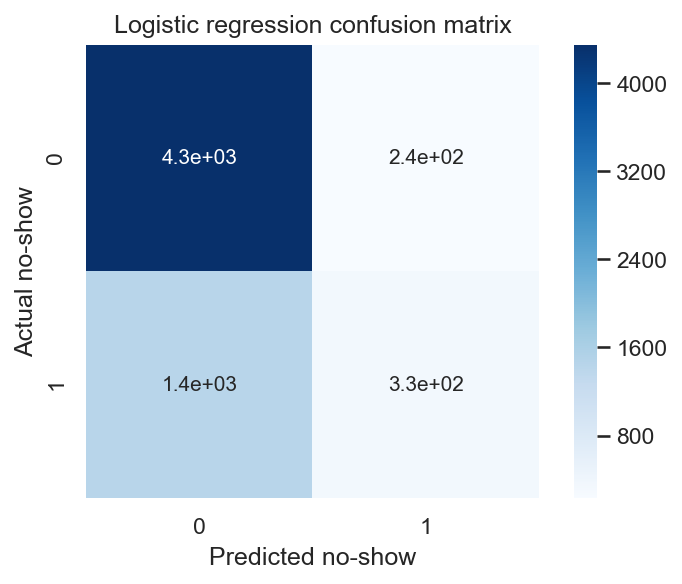

In [24]:
# Print confusion matrix for logistic regression
logit_confusion = confusion_matrix(y_test, y_pred_test2)

graph_conf_matrix(logit_confusion)

In [25]:
thresh = 0.2
y_predict = (lr.predict_proba(X_test2)[:,1] > thresh)
print("Threshold of",thresh,":")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_test, y_predict), 
                                                     recall_score(y_test, y_predict)))

Threshold of 0.2 :
Precision: 0.3236,   Recall: 0.7930


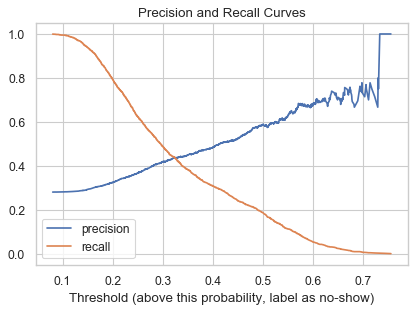

In [26]:
# Graph precision and recall curves
# We can also use the probabilities to make a curve showing us how recall 
# and thresholds trade off 

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, lr.predict_proba(X_test2)[:,1] )

graph_prec_recall_curves(threshold_curve,precision_curve,recall_curve)

In [27]:
# Graph ROC AUC 
fpr, tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test2)[:,1])

ROC AUC score =  0.6475343242094717


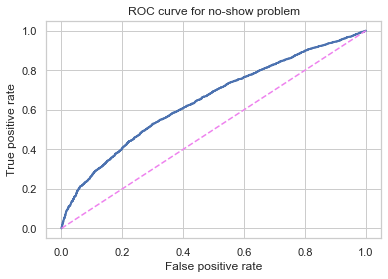

In [28]:
graph_roc_auc(fpr,tpr)
print("ROC AUC score = ", roc_auc_score(y_test, lr.predict_proba(X_test2)[:,1]))

### Predict missing values

In [29]:
with open('pickles/appt_v2_all.pickle','rb') as read_file:
    appt_all = pickle.load(read_file)

In [30]:
appt_all.shape

(71163, 37)

In [31]:
appt_all['no_show_rate2'].describe()
# no show rate is missing for 14k appts

count    25453.000000
mean         0.270794
std          0.399344
min          0.000000
25%          0.000000
50%          0.000000
75%          0.500000
max          1.000000
Name: no_show_rate2, dtype: float64

#### predicting the no show rate

In [32]:
# set up columns
all_cols = ['Gender','Age2','Neighbourhood2','Scholarship','Hipertension','Diabetes','Alcoholism',
                'Handcap_bin','SMS_received','SchedDayofWeek','ApptDayofWeek','DayDiff2','no_show_rate2']
appt_all2 = appt_all[all_cols]
appt_all2 = pd.get_dummies(appt_all2, columns = ['Gender','Neighbourhood2','SchedDayofWeek','ApptDayofWeek'])
appt_all2.drop(columns=['Gender_F','Neighbourhood2_OTHER','SchedDayofWeek_Monday','ApptDayofWeek_Monday'],inplace=True)
X_cols = np.array(appt_all2.columns)

In [33]:
appt_missing = appt_all2.loc[appt_all2['no_show_rate2'].isna()]
appt_notmissing = appt_all2.loc[appt_all2['no_show_rate2'].isna()==False]

In [34]:
X_train, y_train = appt_notmissing.drop(['no_show_rate2'],axis=1), appt_notmissing['no_show_rate2']
X_test, y_test = appt_missing.drop(['no_show_rate2'],axis=1), appt_missing['no_show_rate2']

In [35]:
#Standardize
std = StandardScaler()
std.fit(X_train)
X_train_std = std.transform(X_train)
X_test_std = std.transform(X_test)

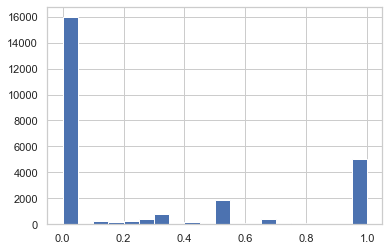

In [36]:
plt.hist(y_train,bins=20);

In [37]:
linreg = LinearRegression()
linreg.fit(X_train_std,y_train)
y_pred = linreg.predict(X_test_std)

In [38]:
y_pred

array([0.21313344, 0.20860071, 0.18057171, ..., 0.28119547, 0.24375698,
       0.14001525])

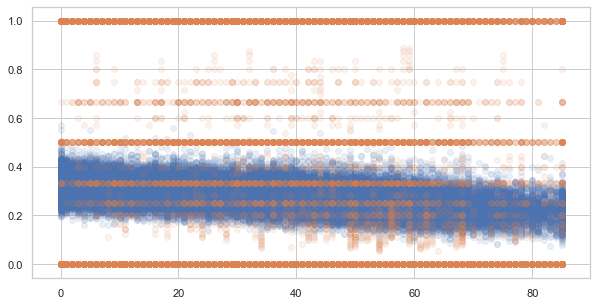

In [39]:
plt.figure(figsize=(10,5))
plt.scatter(X_test['Age2'],y_pred,alpha=0.1)
plt.scatter(X_train['Age2'],y_train,alpha=0.1);

predicting a non-zero mean biases the results -suggests everyone has a no-show history when in reality most people are probably zero

maybe need to predict categorical appt count? and multiply that by this?

#### predicting the prior appt count

In [59]:
# set up columns
all_cols = ['Gender','Age2','Neighbourhood2','Scholarship','Hipertension','Diabetes','Alcoholism',
                'Handcap_bin','SMS_received','SchedDayofWeek','ApptDayofWeek','DayDiff2','total_appt_count2']
appt_all2 = appt_all[all_cols]
appt_all2 = pd.get_dummies(appt_all2, columns = ['Gender','Neighbourhood2','SchedDayofWeek','ApptDayofWeek'])
appt_all2.drop(columns=['Gender_F','Neighbourhood2_OTHER','SchedDayofWeek_Monday','ApptDayofWeek_Monday'],inplace=True)
X_cols = np.array(appt_all2.columns)

In [60]:
appt_missing = appt_all2.loc[appt_all['total_appt_count2'].isna()]
appt_notmissing = appt_all2.loc[appt_all['total_appt_count2'].isna()==False]

In [61]:
X_train, y_train = appt_notmissing.drop(['total_appt_count2'],axis=1), appt_notmissing['total_appt_count2']
X_test, y_test = appt_missing.drop(['total_appt_count2'],axis=1), appt_missing['total_appt_count2']

In [43]:
#Standardize
# std = StandardScaler()
# std.fit(X_train)
# X_train_std = std.transform(X_train)
# X_test_std = std.transform(X_test)

In [44]:
# plt.hist(y_train,bins=20);

In [45]:
# linreg2 = LinearRegression()
# linreg2.fit(X_train,y_train)
# y_pred2 = linreg2.predict(X_test)

In [46]:
# y_pred2

In [47]:
# plt.figure(figsize=(10,5))
# plt.scatter(X_test['Age2'],y_pred2,alpha=0.1)
# plt.scatter(X_train['Age2'],y_train,alpha=0.1);

In [62]:
# predicting with KNN
from sklearn.neighbors import KNeighborsClassifier

KNN = KNeighborsClassifier(n_neighbors=5)
KNN.fit(X_train,y_train)
y_pred_KNN = KNN.predict(X_test)

In [71]:
from collections import Counter
Counter(y_pred_KNN)

Counter({1.0: 40253,
         2.0: 4270,
         3.0: 761,
         5.0: 102,
         6.0: 29,
         7.0: 36,
         4.0: 236,
         8.0: 13,
         9.0: 7,
         11.0: 1,
         10.0: 1,
         12.0: 1})

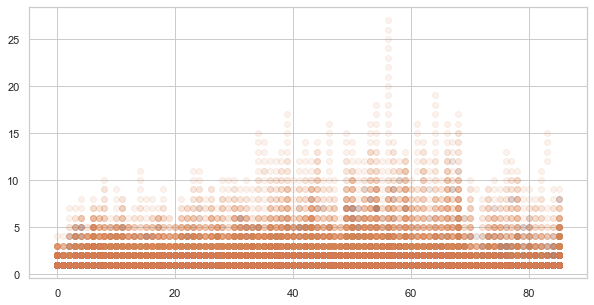

In [63]:
plt.figure(figsize=(10,5))
plt.scatter(X_test['Age2'],y_pred_KNN,alpha=0.1)
plt.scatter(X_train['Age2'],y_train,alpha=0.1);

### Output 2 alternative data sets
- v2_all0: replace all NaNs with zeros
- v2_all1: replace all NaNs with imputed info

In [48]:
appt_all.head(5)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,...,PrevAppt_No_show,PrevAppt_Sched_diff,appt_count,total_appt_count,total_no_show_count,no_show_rate,no_show_rate2,total_appt_count2,Reschedule,Follow_up
65088,3.921784e+04,5751990,F,2016-05-31T10:56:41Z,2016-06-03T00:00:00Z,44,PRAIA DO SUÁ,0,0,0,...,NaN,NaN,1,1,0,0.0,NaN,NaN,0,0
48200,1.417242e+05,5637648,M,2016-04-29T07:13:36Z,2016-05-02T00:00:00Z,12,FORTE SÃO JOÃO,0,0,0,...,NaN,NaN,1,1,0,0.0,NaN,NaN,0,0
48151,5.376153e+05,5637728,F,2016-04-29T07:19:57Z,2016-05-06T00:00:00Z,14,FORTE SÃO JOÃO,0,0,0,...,NaN,NaN,1,1,0,0.0,NaN,NaN,0,0
36948,5.628261e+06,5680449,M,2016-05-10T11:58:18Z,2016-05-13T00:00:00Z,13,PARQUE MOSCOSO,0,0,0,...,NaN,NaN,1,1,1,1.0,NaN,NaN,0,0
39603,2.263866e+07,5580835,F,2016-04-14T07:23:30Z,2016-05-03T00:00:00Z,22,INHANGUETÁ,0,0,0,...,NaN,NaN,1,1,0,0.0,NaN,NaN,0,0


#### v2_all0 - replace all NaNs with 0's

In [49]:
appt_all0 = appt_all.copy()
appt_all0['no_show_rate2'].replace(np.NaN,0,inplace=True)
# appt_all0.head(5)

In [50]:
with open('pickles/appt_v2_all0.pickle', 'wb') as to_write:
    pickle.dump(appt_all0, to_write)

#### v2_all1 - replace all NaNs with imputed rate

In [51]:
appt_missing1 = appt_all.loc[appt_all['no_show_rate2'].isna()]
appt_notmissing1 = appt_all.loc[appt_all['no_show_rate2'].isna()==False]

In [52]:
appt_missing1['no_show_rate2'] = y_pred

/Users/Jocelyn/anaconda3/envs/metis/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [53]:
appt_missing1.head(5)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,...,PrevAppt_No_show,PrevAppt_Sched_diff,appt_count,total_appt_count,total_no_show_count,no_show_rate,no_show_rate2,total_appt_count2,Reschedule,Follow_up
65088,3.921784e+04,5751990,F,2016-05-31T10:56:41Z,2016-06-03T00:00:00Z,44,PRAIA DO SUÁ,0,0,0,...,NaN,NaN,1,1,0,0.0,0.213133,NaN,0,0
48200,1.417242e+05,5637648,M,2016-04-29T07:13:36Z,2016-05-02T00:00:00Z,12,FORTE SÃO JOÃO,0,0,0,...,NaN,NaN,1,1,0,0.0,0.208601,NaN,0,0
48151,5.376153e+05,5637728,F,2016-04-29T07:19:57Z,2016-05-06T00:00:00Z,14,FORTE SÃO JOÃO,0,0,0,...,NaN,NaN,1,1,0,0.0,0.180572,NaN,0,0
36948,5.628261e+06,5680449,M,2016-05-10T11:58:18Z,2016-05-13T00:00:00Z,13,PARQUE MOSCOSO,0,0,0,...,NaN,NaN,1,1,1,1.0,0.247732,NaN,0,0
39603,2.263866e+07,5580835,F,2016-04-14T07:23:30Z,2016-05-03T00:00:00Z,22,INHANGUETÁ,0,0,0,...,NaN,NaN,1,1,0,0.0,0.260144,NaN,0,0


In [54]:
appt_all1 = appt_missing1.append(appt_notmissing1, sort=True)

In [55]:
appt_all1['no_show_rate2'].describe()

count    71163.000000
mean         0.273813
std          0.243446
min          0.000000
25%          0.170475
50%          0.259271
75%          0.323336
max          1.000000
Name: no_show_rate2, dtype: float64

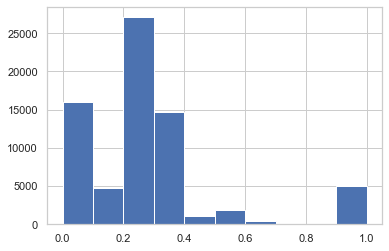

In [56]:
plt.hist(appt_all1['no_show_rate2']);

In [57]:
with open('pickles/appt_v2_all1.pickle', 'wb') as to_write:
    pickle.dump(appt_all1, to_write)